In [1]:
import os
import requests

pdf_path = "Human_Nutrition.pdf"

if not os.path.exists(pdf_path):
    print("Downloading")
    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"
    filename = pdf_path
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"[INFO] The file has been downloaded as {filename}")
    else:
        print(f"[INFO] Failed to download {response.status_code}")
else:
    print(f"File {pdf_path} already exists")

File Human_Nutrition.pdf already exists


In [2]:
import fitz 
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()

    return cleaned_text

def open_and_red_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_texts.append({"page_number": page_number-41,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,
                                "text": text
                               })
    return pages_and_texts

pages_and_texts = open_and_red_pdf(pdf_path=pdf_path)
pages_and_texts[:2]
    


0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [3]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 260,
  'page_char_count': 622,
  'page_word_count': 112,
  'page_sentence_count_raw': 3,
  'page_token_count': 155.5,
  'text': 'Image by  Forluvoft /  Public  Domain  Health Consequences and  Benefits of  High-Carbohydrate Diets  UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  Can America blame its obesity epidemic on the higher consumption  of added sugars and refined grains? This is a hotly debated topic  by both the scientific community and the general public. In this  section, we will give a brief overview of the scientific evidence.  Added Sugars  Figure 4.13 Sugar Consumption (In Teaspoons) From Various  Sources    260  |  Health Consequences and Benefits of High-Carbohydrate Diets'},
 {'page_number': 225,
  'page_char_count': 848,
  'page_word_count': 143,
  'page_sentence_count_raw': 6,
  'page_token_count': 212.0,
  'text': 'Learning Activities  Technology Note: The second edition of the Human  Nutrition O

In [4]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,147,3,199.25,Contents Preface University of Hawai‘i at Mā...


In [5]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00
std,348.86,560.38,95.83,6.55,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,5.00,190.50
50%,562.50,1231.50,216.00,10.00,307.88
75%,864.25,1603.50,272.00,15.00,400.88
max,1166.00,2308.00,430.00,39.00,577.00


* sentence transformers all-mpnet-base-v2

### Further text processing ie splitting pages into sentences
we can do this by
1. splitting on `"."`.
2. NLP library such as spaCy

In [6]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline
nlp.add_pipe("sentencizer")

# create document instance as example
doc = nlp("This is a sentence. another sentence. I like elephants.")
assert len(list(doc.sents)) == 3

# Print out sentences
list(doc.sents)

[This is a sentence., another sentence., I like elephants.]

In [7]:
pages_and_texts[606]

{'page_number': 565,
 'page_char_count': 1418,
 'page_word_count': 226,
 'page_sentence_count_raw': 14,
 'page_token_count': 354.5,
 'text': 'Fact Sheet for Health Professionals, Riboflavin. National Institute  of Health, Office of Dietary Supplements. https://ods.od.nih.gov/ factsheets/Riboflavin-HealthProfessional/. Updated February 11,  2016. Accessed October 22, 2017.  Niacin (B3)  Niacin is a component of the coenzymes NADH and NADPH, which  are involved in the catabolism and/or anabolism of carbohydrates,  lipids, and proteins. NADH is the predominant electron carrier and  transfers electrons to the electron-transport chain to make ATP.  NADPH is also required for the anabolic pathways of fatty-acid  and cholesterol synthesis. In contrast to other vitamins, niacin can  be synthesized by humans from the amino acid tryptophan in an  anabolic process requiring enzymes dependent on riboflavin,  vitamin B6, and iron. Niacin is made from tryptophan only after  tryptophan has met all of

In [8]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings. Default is a spaCy Datatype
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [9]:
random.sample(pages_and_texts, k=1)

[{'page_number': 1129,
  'page_char_count': 1353,
  'page_word_count': 233,
  'page_sentence_count_raw': 20,
  'page_token_count': 338.25,
  'text': '• Unusual interest in the health of what others are eating  • Spending hours per day thinking about what food might be  served at upcoming events  • Showing high levels of distress when ‘safe’ or ‘healthy’ foods  are not available  • Obsessive following of food and ‘healthy lifestyle’ blogs on  social media  • Body image concerns may or may not present  The Healing Process  With all wounds, from a paper cut to major surgery, the body must  heal itself. Healing is facilitated through proper nutrition while  malnutrition inhibits and complicates this vital process. The  following nutrients are important for proper healing:13  • Vitamin A. Helps to enable the epithelial tissue (the thin outer  layer of the body and the lining that protects your organs) and  bone cells form.  • Vitamin C. Helps form collagen, an important protein in many  bod

In [10]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32
std,348.86,560.38,95.83,6.55,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00


### Chunking our sentences together
Concept of splitting larger pieces of text into smaller ones is called chunking. There is no 100% correct way to do this.

Keep it simple and split into groups of 10 sentences

Frameworks such as LangChain help with this. But here we will just stick to python.

We do this because:
1. Texts are easier to filter and inspect than larger passages
2. Text chunks can fit into embedding model context window eg 384 tokens
3. Contexts passed to LLM can be more specific and focused

In [11]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create function to split lists of texts recursively into chunk size
# eg [20] -> [10, 10] or [25] -> [10,10,5]

def split_list(input_list: list,
              slice_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [12]:
# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item['sentence_chunks'] = split_list(input_list=item["sentences"],
                                        slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [13]:
random.sample(pages_and_texts, k=2)

[{'page_number': 1112,
  'page_char_count': 1896,
  'page_word_count': 321,
  'page_sentence_count_raw': 22,
  'page_token_count': 474.0,
  'text': 'For Type 2 diabetics, the onset of symptoms is more gradual and  less noticeable than for Type 1 diabetics. The first stage of Type  2 diabetes is characterized by high glucose and insulin levels. This  is because the insulin-secreting cells in the pancreas attempt to  compensate for insulin resistance by making more insulin. In the  second stage of Type 2 diabetes, the insulin-secreting cells in the  pancreas become exhausted and die. At this point, Type 2 diabetics  also have to be treated with insulin injections. Healthcare providers  is to prevent the second stage from happening. As with Type 1  diabetes, chronically high-glucose levels cause big detriments to  health over time, so another goal for patients with Type 2 diabetes  is to properly manage their blood-glucose levels. The front-line  approach for treating Type 2 diabetes incl

In [14]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2) 

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32,1.53
std,348.86,560.38,95.83,6.55,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00,1.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00,1.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00,2.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00,3.00


### Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own numerical representation

It will give us a good level of granularity

Meaning, we can specifically dive into the text sample that was used in the model.

In [15]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a patagraph like structure. aka join the list of sentences into one para
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r"\.([A-Z])", r". \1", joined_sentence_chunk) # ".A" -> ". A"

        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # some stats on chunks
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = 4 chars

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [16]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 1059,
  'sentence_chunk': 'Diet Pros Cons DASH Diet • Recommended by the National Heart, Lung, and Blood Institute, the American Heart Association, and many physicians • Helps to lower blood pressure and cholesterol • Reduces risk of heart disease and stroke • Reduces risk of certain cancers • Reduces diabetes risk • There are very few negative factors associated with the DASH diet • Risk for hyponatremia Gluten-Free Diet • Reduces the symptoms of gluten intolerance, such as chronic diarrhea, cramping, constipation, and bloating • Promotes healing of the small intestines for people with celiac disease, preventing malnutrition • May be beneficial for other autoimmune diseases, such as Parkinson’s disease, rheumatoid arthritis, and multiple sclerosis • Risk of folate, iron, thiamin, riboflavin, niacin, and vitamin B6 deficiencies • Special gluten-free products can be hard to find and expensive • Requires constant vigilance and careful food label reading, since gluten is 

In [17]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.10,112.74,183.52
std,347.79,447.51,71.24,111.88
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,745.00,115.00,186.25
75%,890.00,1118.00,173.00,279.50
max,1166.00,1830.00,297.00,457.50


### Filter chunks of text for short chunks

These may not contain useful information

In [18]:
# Show random chunks with under 30 tokens of data
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f"Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}")

Chunk token count: 28.0 | Text: Fluid balance refers to maintaining the distribution of water in the body. 386 | Protein’s Functions in the Body
Chunk token count: 11.25 | Text: Accessed March 17, 2011. 212 | Water Concerns
Chunk token count: 20.5 | Text: PART III CHAPTER 3. WATER AND ELECTROLYTES Chapter 3. Water and Electrolytes | 143
Chunk token count: 16.75 | Text: PART XI CHAPTER 11. TRACE MINERALS Chapter 11. Trace Minerals | 649
Chunk token count: 5.25 | Text: 754 | MyPlate Planner


In [19]:
# Filter df for rows with under 30 tokens
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [20]:
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_number': 1159,
  'sentence_chunk': '32. Figure 15.2 reused “Two Women Riding Bikes” by David Marcu/ Unsplash License 33. Figure 15.reused “Man wearing blue shirt standing on white surfboard” by Alex Blajan / Unsplash License 34. Figure 16.3 Anaerobic versus Aerobic Metabolism by Allison Calabrese / CC BY 4.0 35. Figure 16.4 The Effect of Exercise Duration on Energy Systems” by Allison Calabrese / CC BY 4.0 36. Figure 16.5 “Fuel Sources for Anaerobic and Aerobic Metabolism reused “Liver” by Maritacovarrubias / Public Domain; “Bread” by Jack7 / Public Domain; “Muscle types” by Bruce Balus / CC BY-SA 4.0; “Tango style chicken leg” by Rugby471 / Public Domain; “Male body silhouette” by mlampret / Public Domain 37. Figure 16.6 The Effect of Exercise Intensity on Fuel Sources reused “Happy reading guy” from Max Pixel / CC0; “Surfers surfing waters” by hhach / CC0; “Football runner ball” by Skeeze / CC0 38. Figure 16.7 Relative Energy Deficiency in Sport Effects reused woman running i

### Embedding our text chunks

Humans understand text but machines understand numbers

Turn chunks into numbers

They are a learned representation

Vicky Boykis embeddings

In [21]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path = "all-mpnet-base-v2",
                                     device="cpu") # or choose any pretrained model from sbert.net
# Create a list of sentences
sentences = ["The Sentence Transformer library provides an easy way to create embeddings.",
             "Sentences can be embedded one by one or in a list",
             "I Like Horses!"]

# Sentences are embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See embeddings
for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding}")
    print()


C:\Anaconda\envs\RAG\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Anaconda\envs\RAG\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence: The Sentence Transformer library provides an easy way to create embeddings.
Embedding: [-3.44286300e-02  2.95328330e-02 -2.33643539e-02  5.57257496e-02
 -2.19098590e-02 -6.47060527e-03  1.02848671e-02 -6.57803118e-02
  2.29718108e-02 -2.61121094e-02  3.80420424e-02  5.61403073e-02
 -3.68746668e-02  1.52787855e-02  4.37020473e-02 -5.19723520e-02
  4.89479750e-02  3.58107663e-03 -1.29750716e-02  3.54384189e-03
  4.23262566e-02  3.52606587e-02  2.49402728e-02  2.99176984e-02
 -1.99382678e-02 -2.39752326e-02 -3.33366124e-03 -4.30450439e-02
  5.72014190e-02 -1.32517805e-02 -3.54477949e-02 -1.13936048e-02
  5.55561259e-02  3.61094647e-03  8.88527097e-07  1.14026899e-02
 -3.82230096e-02 -2.43546255e-03  1.51314037e-02 -1.32734815e-04
  5.00659980e-02 -5.50876148e-02  1.73444897e-02  5.00959419e-02
 -3.75959203e-02 -1.04463520e-02  5.08322567e-02  1.24861356e-02
  8.67377147e-02  4.64143082e-02 -2.10690200e-02 -3.90251614e-02
  1.99694349e-03 -1.42345466e-02 -1.86794717e-02  2.826694

In [22]:
embeddings[0].shape

(768,)

In [23]:
embedding = embedding_model.encode("My favourite animal is the cow")
embedding

array([-8.87764711e-03,  8.35835114e-02, -2.81862896e-02, -3.71655039e-02,
        2.18684189e-02,  5.61196208e-02, -7.55760372e-02,  1.01799173e-02,
        1.48691228e-02, -2.08466779e-02, -2.89396252e-02,  4.55776230e-02,
       -3.03733516e-02, -1.41894370e-02, -1.61682945e-02, -3.85183096e-02,
        3.52857709e-02,  5.25922794e-03, -2.22115219e-02,  3.23855318e-02,
       -2.36056801e-02,  4.16592620e-02, -1.16741182e-02, -2.24949699e-02,
       -1.69876497e-02,  8.03108979e-03, -3.82865430e-03, -2.72515398e-02,
        2.71817017e-02,  2.64697839e-02, -6.16850406e-02, -8.03409293e-02,
        2.93563269e-02, -2.60433573e-02,  1.26088582e-06,  7.68714352e-03,
       -2.78717410e-02,  5.80594223e-03,  4.93111536e-02, -4.50253207e-03,
        3.92273488e-03,  1.44862523e-02, -1.33295404e-02,  1.35614555e-02,
        1.89375933e-02,  6.01764396e-02,  4.52522449e-02,  1.80459600e-02,
       -9.52361226e-02,  2.16227304e-02, -3.90326697e-03, -2.29934156e-02,
       -3.01052500e-02, -

In [24]:
%%time

# embedding_model.to("cpu")

# # Embed each chunk one by one
# for item in tqdm(pages_and_chunks_over_min_token_len):
#     item["embedding"] = embedding_model.encode(item['sentence_chunk'])



CPU times: total: 0 ns
Wall time: 0 ns


In [25]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [26]:
torch.cuda.is_available()

True

In [29]:
%%time

embedding_model.to('cuda')
# Embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item['sentence_chunk'])


  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: total: 2min 41s
Wall time: 1min 1s


In [30]:
%%time

text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
text_chunks[419]

CPU times: total: 0 ns
Wall time: 1 ms


'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity. The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods. Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture to their fascinating food creations. Add

In [31]:
len(text_chunks)

1680

In [32]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks, 
                                               batch_size=32, # experiment to find which batch size leads to best results
                                               convert_to_tensor=True
                                              )

text_chunk_embeddings

CPU times: total: 22.5 s
Wall time: 25.5 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

In [34]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [35]:
# Import saved file and view
text_chunks_and_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embeddings_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242303e-02 9.02281180e-02 -5.09547815e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156195e-02 5.92139065e-02 -1.66167300e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,[ 2.79801860e-02 3.39813903e-02 -2.06426550e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,[ 6.82566985e-02 3.81274670e-02 -8.46855156e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264494e-02 -8.49769637e-03 9.57157742e-...


If your embedding database is very large, use a vector database. 100k-1M sample

### RAG Search and Answer

RAG Goal: Retrieve relevant passages based on a query and use those passages to augment an input to an LLM so that it can generate an output based on those relevant passages.

### Similarity Search

Embeddings can be used for almost any types of data.

Eg Images, sounds, text etc

Comparing embeddings is known as similarity search, vector search, semantic search

We want to query nutrition textbook for passages based on semantics.


In [2]:
import random
import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embeddings df
text_chunks_and_embeddings_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embeddings column into np array (got converted to string when saved as csv)
text_chunks_and_embeddings_df["embedding"] = text_chunks_and_embeddings_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert embeddings into torch tensor
embeddings = torch.tensor(np.stack(text_chunks_and_embeddings_df["embedding"].to_list(), axis=0), dtype=torch.float32).to("cuda")

# Convert texts and embeddings df to list of dicts
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient="records")

text_chunks_and_embeddings_df

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242303, 0.090228118, -0.00509547815, -0..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156195, 0.0592139065, -0.01661673, -0.0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,"[0.027980186, 0.0339813903, -0.020642655, 0.00..."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,"[0.0682566985, 0.038127467, -0.00846855156, -0..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264494, -0.00849769637, 0.00957157742, ..."
...,...,...,...,...,...,...
1675,1164,Flashcard Images Note: Most images in the flas...,1304,186,326.00,"[0.0185622461, -0.0164277442, -0.0127045643, -..."
1676,1164,Hazard Analysis Critical Control Points reused...,374,51,93.50,"[0.0334720686, -0.0570440851, 0.015148934, -0...."
1677,1165,ShareAlike 11. Organs reused “Pancreas Organ A...,1285,175,321.25,"[0.0770515427, 0.00978557114, -0.0121817337, 0..."
1678,1165,Sucrose reused “Figure 03 02 05” by OpenStax B...,410,63,102.50,"[0.103045151, -0.016470179, 0.00826843269, 0.0..."


In [2]:
text_chunks_and_embeddings_df["embedding"]

0       [0.0674242303, 0.090228118, -0.00509547815, -0...
1       [0.0552156195, 0.0592139065, -0.01661673, -0.0...
2       [0.027980186, 0.0339813903, -0.020642655, 0.00...
3       [0.0682566985, 0.038127467, -0.00846855156, -0...
4       [0.0330264494, -0.00849769637, 0.00957157742, ...
                              ...                        
1675    [0.0185622461, -0.0164277442, -0.0127045643, -...
1676    [0.0334720686, -0.0570440851, 0.015148934, -0....
1677    [0.0770515427, 0.00978557114, -0.0121817337, 0...
1678    [0.103045151, -0.016470179, 0.00826843269, 0.0...
1679    [0.0863773525, -0.0125358729, -0.0112746907, 0...
Name: embedding, Length: 1680, dtype: object

In [48]:
embeddings.shape

torch.Size([1680, 768])

In [3]:
device

'cuda'

In [3]:
# Create Model
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device = device)

C:\Anaconda\envs\RAG\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Anaconda\envs\RAG\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Embedding model ready

Create small Semantic Search Pipeline

In essence we want to search for a query and get back relevant passages from our textbook

Follow steps:
1. Define query String
2. Turn query string into embedding
3. Perform dot prod or cosine similarity function between text embedding and query embedding
4. Sort the results from 3 in descending order

In [4]:
# 1. Define query
query = "good foods for protein"
print(f"Query: {query}")

# 2. Embed query
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to("cuda")

# 3. Perform Dot Prod or Cosine similarity if outputs of model arent normalised
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# Get top k results (5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product


Query: good foods for protein
[INFO] Time taken to get scores on 1680 embeddings: 0.00227 seconds.


torch.return_types.topk(
values=tensor([0.7729, 0.7647, 0.6743, 0.6743, 0.6634], device='cuda:0'),
indices=tensor([611, 616, 615, 620, 617], device='cuda:0'))

In [6]:
pages_and_chunks[42]

{'page_number': 5,
 'sentence_chunk': 'Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are molecules composed of car

We can see that searching over embeddings is very fast even if we do exhaustive search.

But if we had 10+M embeddings, we would want to create an index.

An index is like letters in a dictionary.

For example, to search for "duck", we search for d, then du... then duc... and so on.

An index helps narrow it down

Popular indexing library for vector search is FAISS. Facebook AI Similarity Search.

Approximate nearest neighbout search (ANN) is one of the techniques.

Let's make vector search function pretty

In [5]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [6]:
print(f"Query: '{query}' \n")
print("Results")
# Loop through zipped scores and indeces from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score: .4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page Number: {pages_and_chunks[idx]["page_number"]}")
    print()

Query: 'good foods for protein' 

Results
Score:  0.7729
Text:
Dietary Sources of Protein The protein food group consists of foods made from
meat, seafood, poultry, eggs, soy, dry beans, peas, and seeds. According to the
Harvard School of Public Health, “animal protein and vegetable protein probably
have the same effects on health. It’s the protein package that’s likely to make
a difference.”1 1. Protein: The Bottom Line. Harvard School of Public Proteins,
Diet, and Personal Choices | 411
Page Number: 411

Score:  0.7647
Text:
Additionally, a person should consume 8 ounces of cooked seafood every week
(typically as two 4-ounce servings) to assure they are getting the healthy
omega-3 fatty acids that have been linked to a lower risk for heart disease.
Another tip is choosing to eat dry beans, peas, or soy products as a main dish.
Some of the menu choices include chili with kidney and pinto beans, hummus on
pita bread, and black bean enchiladas. You could also enjoy nuts in a variety of


Note: We could potentially improve the order of these results with a rereanking model. A model that has been specifically trained to take search reults (eg top 25 semantic results) and then rank them from most likely top-1 to least likely.

Open source reranking model: mxbai rerank large v1

To check our results, what if we wanted to automatically surface the page of texts related to our query?

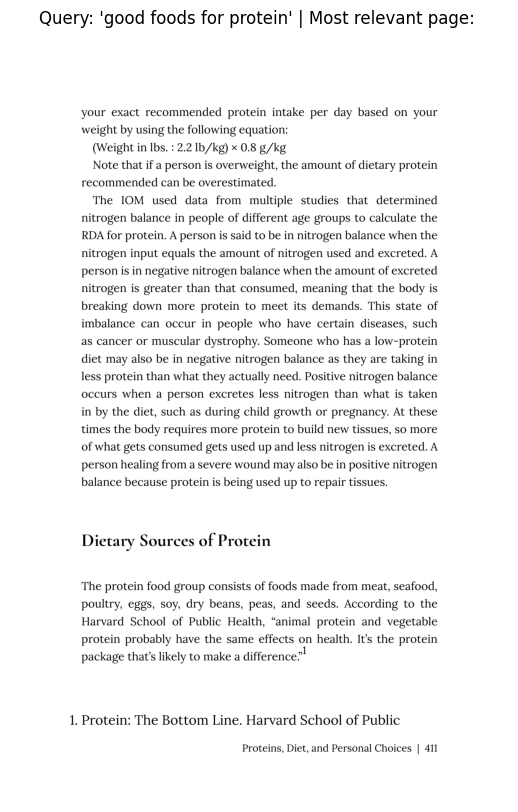

In [7]:
import fitz

# Open PDF and load target
pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(411+41) # Page numbers of our PDF start at 41+

# Get img of page
img = page.get_pixmap(dpi=300)

# Save image optinal
# img.save("output_filename.png") 

doc.close()

# Convert pixmap to numpy array
img_array = np.frombuffer(img.samples_mv, 
                          dtype=np.uint8).reshape((img.h, img.w, img.n))
# img_array

# Display the image using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13,10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page: ")
plt.axis("off")
plt.show()

### Similarity measures: dot product and cosine similarity

In [8]:
import torch

def dot_product(vec1, vec2):
    return torch.dot(vec1, vec2)

def cosine_similarity(vec1, vec2):
    dot_prod = torch.dot(vec1, vec2)

    # Get L2 Norm
    norm_vec1 = torch.sqrt(torch.sum(vec1**2))
    norm_vec2 = torch.sqrt(torch.sum(vec2**2))

    return dot_prod / (norm_vec1 * norm_vec2)

# examples vectors
vec1 = torch.tensor([1,2,3], dtype=torch.float32)
vec2 = torch.tensor([1,2,3], dtype=torch.float32)
vec3 = torch.tensor([4,5,6], dtype=torch.float32)
vec4 = torch.tensor([-1,-2,-3], dtype=torch.float32)

# calc dot prod
print("Print dot prod bw vec1 and vec2: ", dot_product(vec1, vec2))
print("Print dot prod bw vec1 and vec3: ", dot_product(vec1, vec3))
print("Print dot prod bw vec1 and vec4: ", dot_product(vec1, vec4))

# Cosine similarity
print("cosine similarity bw vec1 and vec2", cosine_similarity(vec1, vec2))
print("cosine similarity bw vec1 and vec3", cosine_similarity(vec1, vec3))
print("cosine similarity bw vec1 and vec4", cosine_similarity(vec1, vec4))

Print dot prod bw vec1 and vec2:  tensor(14.)
Print dot prod bw vec1 and vec3:  tensor(32.)
Print dot prod bw vec1 and vec4:  tensor(-14.)
cosine similarity bw vec1 and vec2 tensor(1.0000)
cosine similarity bw vec1 and vec3 tensor(0.9746)
cosine similarity bw vec1 and vec4 tensor(-1.0000)


Above, we can see that dot prod between 1 and 3 shows that 3 is doubly as similar to 1 as 1 is to 2. But we want 2 to be most similar to 1 as they are the same. therefore cosine similarity showed that they are.

If outputs of model are already normalised then use dot_prod. If they are not normalised then use cosine similarity. For our model, output embeddings are already normalised.

### Functionalise semantic search pipeline

In [9]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with a model and returns top k scores and indices from embeddings
    """
    # Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Get dot prod scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to print scores on {len(embeddings)} embeddings: {end_time - start_time: .5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor, 
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Finds relevant passages given a query and prints them along with their scores.
    """
    scores, indices = retrieve_relevant_resources(query=query, embeddings = embeddings, n_resources_to_return=n_resources_to_return)
    for score, idx in zip(scores, indices):
        print(f"Score: {score: .4f}")
        print("Text:")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page Number: {pages_and_chunks[idx]["page_number"]}")
        print()

In [10]:
query = "foods high in fiber"
# retrieve_relevant_resources(query="foods high in fiber", embeddings=embeddings)
print_top_results_and_scores(query = query, embeddings=embeddings)

[INFO] Time taken to print scores on 1680 embeddings:  0.00007 seconds.
Score:  0.6964
Text:
• Change it up a bit and experience the taste and satisfaction of other whole
grains such as barley, quinoa, and bulgur. • Eat snacks high in fiber, such as
almonds, pistachios, raisins, and air-popped popcorn. Add an artichoke and green
peas to your dinner plate more 276 | Carbohydrates and Personal Diet Choices
Page Number: 276

Score:  0.6810
Text:
Dietary fiber is categorized as either water-soluble or insoluble. Some examples
of soluble fibers are inulin, pectin, and guar gum and they are found in peas,
beans, oats, barley, and rye. Cellulose and lignin are insoluble fibers and a
few dietary sources of them are whole-grain foods, flax, cauliflower, and
avocados. Cellulose is the most abundant fiber in plants, making up the cell
walls and providing structure. Soluble fibers are more easily accessible to
bacterial enzymes in the large intestine so they can be broken down to a greater
extent 

### Getting an LLM for local generation

### Checking local GPU memory

In [11]:
import torch

gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / 2**30)
print(f"Availible memory is {gpu_memory_gb}")

Availible memory is 6


In [14]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 6 | Recommended model: Gemma 2B in 4-bit precision.
use_quantization_config set to: True
model_id set to: google/gemma-2b-it


### Loading an LLM locally

To run a model locally we need a few things
1. A quantization config (optional) - a config on what precision to load the model in eg. 4 bit 8 bit etc
2. A model ID - will tell transformers which model/tokenizer to load
3. A tokenizer - this turns text into numbers ready for LLM (diff from an embedding model)
4. An LLM Model

>**Note** Check Flash Attention 2 from github

In [15]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# Create a quantization config
# Requires pip install bitsandbytes accelerate
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Flash attn 2 = faster attn mechanism
# Flash attn 2 requires a gpu with a compute capability score of 8.0+
if (is_flash_attn_2_available()) and torch.cuda.get_device_capability(0)[0] >= 8:
    attn_implementation = "flash_attention_2"
else:
    attn_implementation = "sdpa" # scaled dot prod attention

print(f"Using attn implementation: {attn_implementation}")

# Pick a model we'd like to use
model_id = model_id # google/gemma-2b-it

# Instantiate Tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16,
                                                 quantization_config=quantization_config if use_quantization_config else None, 
                                                 low_cpu_mem_usage=False,
                                                 attn_implementation=attn_implementation)

if not use_quantization_config:
    llm_model.to("cuda")

Using attn implementation: sdpa


C:\Anaconda\envs\RAG\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
     

In [18]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

1515268096

In [19]:
def get_model_mem_size(model: torch.nn.Module):
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate model sizes
    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / 1024**2
    model_mem_gb = model_mem_bytes / 1024**3

    return {"model_mem_bytes": model_mem_bytes, 
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 2106740736, 'model_mem_mb': 2009.14, 'model_mem_gb': 1.96}

In [20]:
!nvidia-smi

Wed Jun 26 14:46:31 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.85                 Driver Version: 555.85         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   40C    P8              5W /   30W |    2782MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Generate Text with our LLM

Let's generate text with our LLM

Some models have been trained/tuned to generate text with a certain template in mind

Since Gemma-2b-it is trained in an instruction-tuned manner, we should follow the instruction template in our model for best results

In [21]:
input_text = "What are macronutrients, and what role do they play in the human body?"
print(f"Input text: {input_text}")

# create a prompt template for instruction tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False,
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted): \n{prompt}")

Input text: What are macronutrients, and what role do they play in the human body?

Prompt (formatted): 
<bos><start_of_turn>user
What are macronutrients, and what role do they play in the human body?<end_of_turn>
<start_of_turn>model



In [22]:
tokenizer

GemmaTokenizerFast(name_or_path='google/gemma-2b-it', vocab_size=256000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<start_of_turn>', '<end_of_turn>']}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	5: AddedToken("<2mass>", rstrip=False, lstrip=False, single_w

In [23]:
%%time

# Tokenize input text (turn into numbers and send it to gpu)
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")


# Generate outputs from local LLM
outputs = llm_model.generate(**input_ids, max_new_tokens=256)
print(f"Model outputs (tokens): \n {outputs[0]}")

C:\Anaconda\envs\RAG\Lib\site-packages\transformers\models\gemma\modeling_gemma.py:561: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Model outputs (tokens): 
 tensor([     2,      2,    106,   1645,    108,   1841,    708, 186809, 184592,
        235269,    578,   1212,   4731,    749,    984,   1554,    575,    573,
          3515,   2971, 235336,    107,    108,    106,   2516,    108,  21404,
        235269,   1517, 235303, 235256,    476,  11352,  15844,    576, 186809,
        184592,    578,   1024,  16065,    575,    573,   3515,   2971, 235292,
           109,    688,  12298,   1695, 184592,    688,    708,  37132,    674,
           573,   2971,   4026,    575,   2910,  15992,    577,  10528,   1426,
          2962, 235265,   3766,  37132,    708,   8727,    604,   4282,  55786,
          7257, 235269,   3359, 235292,    109,    688, 235274, 235265,  33849,
         66058,    109, 235287,  33849,    603,   8727,    604,   4547,    578,
         68808,  29703, 235269,   3547,  44760, 235269,    578,  17839,  53186,
           578,  43083, 235265,    108, 235287,   1165,    603,   1942,    575,
          8205

In [24]:
# decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model Output (decoded): \n{outputs_decoded}\n")

Model Output (decoded): 
<bos><bos><start_of_turn>user
What are macronutrients, and what role do they play in the human body?<end_of_turn>
<start_of_turn>model
Sure, here's a detailed explanation of macronutrients and their roles in the human body:

**Macronutrients** are nutrients that the body needs in large amounts to maintain good health. These nutrients are essential for various bodily functions, including:

**1. Protein:**

* Protein is essential for building and repairing tissues, making enzymes, and producing hormones and antibodies.
* It is found in animal products, legumes, nuts, and seeds.

**2. Carbohydrates:**

* Carbohydrates are the body's main source of energy.
* They are found in fruits, vegetables, grains, and starchy foods.
* They provide energy for physical activity and brain function.

**3. Fat:**

* Fat is a vital nutrient for hormone production, cell growth, and insulation.
* It is found in animal products, nuts, seeds, and olive oil.
* Too much fat can lead to o

In [25]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions
query_list

['What are the macronutrients, and what roles do they play in the human body?',
 'How do vitamins and minerals differ in their roles and importance for health?',
 'Describe the process of digestion and absorption of nutrients in the human body.',
 'What role does fibre play in digestion? Name five fibre containing foods.',
 'Explain the concept of energy balance and its importance in weight management.',
 'How often should infants be breastfed?',
 'What are symptoms of pellagra?',
 'How does saliva help with digestion?',
 'What is the RDI for protein per day?',
 'water soluble vitamins']

In [26]:
import random
query = random.choice(query_list)
print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query, 
                                              embeddings=embeddings)

scores, indices 

Query: How do vitamins and minerals differ in their roles and importance for health?
[INFO] Time taken to print scores on 1680 embeddings:  0.00009 seconds.


(tensor([0.6322, 0.6220, 0.6187, 0.6178, 0.6128], device='cuda:0'),
 tensor([ 51,  47, 874,  41, 927], device='cuda:0'))

### Augmenting our prompt with context items

We've done retreival.

We've done generation.

Time to Augment

The concept of augmenting a prompt with context items is also reffered to as prompt engineering.

It is an active field of research and many new styles are being found

We're going to use a couple of prompting techniques:
1. Give clear instructions
2. Give a few examples of input/output ie Given an input, give this output
3. Give room to think. eg. show your working space or lets think step by step

Lets write a function to format a prompt with context items

In [27]:
pages_and_chunks[420]

{'page_number': 277,
 'sentence_chunk': 'Due to the potential health consequences of consuming too many added sugars, sugar substitutes have replaced them in many foods and beverages. Sugar substitutes may be from natural sources or artificially made. Those that are artificially made are called artificial sweeteners and must be approved by the FDA for use in foods and beverages. The artificial sweeteners approved by the FDA are saccharin, aspartame, acesulfame potassium, neotame, advantame, and sucralose. Stevia is an example of a naturally derived sugar substitute. It comes from a plant commonly known as sugarleaf Carbohydrates and Personal Diet Choices | 277',
 'chunk_char_count': 627,
 'chunk_word_count': 96,
 'chunk_token_count': 156.75,
 'embedding': array([ 7.17155710e-02, -1.32572874e-02,  3.02814562e-02, -3.60341631e-02,
         3.26127522e-02, -5.67361675e-02, -4.58087996e-02, -1.58360763e-03,
         5.18129840e-02, -4.14766632e-02,  2.68277638e-02,  4.33653742e-02,
       

In [52]:
def prompt_formatter(query: str, 
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Don't just return the context items. Use the context items as your knowledge base to generate a meaningful and informed answer.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query   
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [53]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
    
# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: What are symptoms of pellagra?
[INFO] Time taken to print scores on 1680 embeddings:  0.00025 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Don't just return the context items. Use the context items as your knowledge base to generate a meaningful and informed answer.

Now use the following context items to answer the user query:
- Niacin deficiency is commonly known as pellagra and the symptoms include fatigue, decreased appetite, and indigestion. These symptoms are then commonly followed by the four D’s: diarrhea, dermatitis, dementia, and sometimes death. Figure 9.12 Conversion of Tryptophan to Niacin Water-Soluble Vitamins | 565
- car. Does it drive faster with a half-tank of gas or a full one?It does not matter; the car drives just as fast as long as it has gas. Similarly, depletion of B vitamins will cause problems in e

In [54]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt 

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: What are symptoms of pellagra?
RAG answer:
<bos>Sure, here's the answer to the user's query about the symptoms of pellagra:

Symptoms of pellagra include:

- Diarrhea
- Dermatitis
- Dementia
- Even death<eos>
CPU times: total: 797 ms
Wall time: 3.93 s


### Functionalise our LLM answering feature

Wouldn't be cool if our RAG Pipeline worked from a single function?

That is, input a query and you get a generated answer + optionally also get the source document (the context) where the answer was generated from.

Following function achieves this functionality.

In [55]:
def ask(query: str,
        temperature: float=0.7, 
        max_new_tokens: int=256,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer based on the relevant resources.
    """
    # RETREIVAL
    # Get just scores and indices of top related queries
    scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add a score to the context items
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()

    # AUGMENTATION
    # Create a prompt and format it with context items
    prompt = prompt_formatter(query=query, context_items=context_items)

    # tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # GENERATION
    # Generate an output from LLM
    outputs = llm_model.generate(**input_ids, 
                                 temperature=temperature, 
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Decode the tokens into text
    output_text = tokenizer.decode(outputs[0])

    # Format the answer
    if format_answer_text:
        # replace prompt and special tokens
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "")

    if return_answer_only:
        return output_text

    return output_text, context_items



In [62]:
query=random.choice(query_list)
# query = "What is the RDI for protein?"
print(f"query: {query}")
ask(query=query, temperature=0.7)

query: What are the macronutrients, and what roles do they play in the human body?
[INFO] Time taken to print scores on 1680 embeddings:  0.00007 seconds.


"Sure, here's a summary of the relevant passages from the context:\n\n**Macronutrients**\n\n- Carbohydrates provide energy for the body by converting chemical bonds in food into cellular energy.\n- Lipids assist in the process as cofactors or components of enzymes.\n- Proteins provide structure to bones, muscles and skin, and play a role in conducting most of the chemical reactions that take place in the body.\n\nThese nutrients are necessary for the body to function properly and maintain overall health."

query: What is the RDI for protein per day? Error

In [63]:
retrieve_relevant_resources(query, embeddings)

[INFO] Time taken to print scores on 1680 embeddings:  0.00026 seconds.


(tensor([0.7302, 0.7233, 0.6962, 0.6942, 0.6416], device='cuda:0'),
 tensor([42, 47, 46, 41, 52], device='cuda:0'))

In [64]:
pages_and_chunks[42]

{'page_number': 5,
 'sentence_chunk': 'Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are molecules composed of car